# Task Dependency Principles

Objective:

> Learning how ML workflows can be representated using acyclic task graphs, how to construct them and how they are essential to portability.

Principles:

1. Workflows are represented using dependencies of their tasks modeled by _acyclic graphs_.
2. The actual task graph can be displayed when selecting the `graphviz` runner.
3. Individual tasks are implemented using **stateless** or **stateful** **actors**.
4. Both the **train** and **apply** modes of the same pipeline are represented using tightly coupled but distinct task graphs.
5. Operators are reusable components that facilitate the construction of a task graph topology.
6. Operator composition is a non-linear process combining two operators to produce more complex task graph topology.
7. Task graphs can be executed using different runners.

## Workflow Paradigm

![taskgraph](img/taskgraph.svg)

* _conventional programming_ involves direct coding of the processing logic using entities of the given language
* _workflow-based programming_ adds an extra layer on top breaking the logic into steps with defined dependencies and data exchanges
* such workflow is represented using a _directed acyclic graph_ (DAG)
* allows for introspection, scheduling, scalability, reusablity, portability

### Runner Portability

General ability to transcode DAGs at runtime to be launched using different executors.

Let's demonstrate this capability by executing the following artifact using three possible runners:

In [1]:
from forml import project
from forml.pipeline import payload
from dummycatalog import Foo

SOURCE = project.Source.query(Foo)
PIPELINE = payload.ToPandas()
PROJECT = SOURCE.bind(PIPELINE)

#### Dask Runner

[Dask](https://www.dask.org/) is configured as the default runner on this _tutorial platform_ so it gets used just like this:

In [2]:
PROJECT.launcher.apply()

,Timestamp,Label,Level,Value,Bar
0,2021-05-05 03:12:19,1,Alpha,0.26,1
1,2021-05-11 11:27:50,0,Tango,0.94,3
2,2021-05-11 17:35:27,0,Zulu,0.57,4
3,2021-05-06 19:49:43,0,Uniform,0.69,2
4,2021-05-12 08:53:35,0,Xray,0.83,5
5,2021-05-12 22:06:04,0,Victor,0.61,6
6,2021-05-07 13:17:43,1,Echo,0.12,1
7,2021-05-13 16:25:18,0,Whiskey,0.78,3
8,2021-05-13 06:31:58,0,November,0.92,4
9,2021-05-08 15:48:20,0,Yankee,0.68,5


#### Spark Runner

[Apache Spark](https://spark.apache.org/) can be explicitly selected to execute the workflow.

(Hint: if you are quick enough, you can visit the Spark Dashboard at http://localhost:4040/ while the workflow is running)

In [3]:
PROJECT.launcher(runner='spark').apply()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/05/28 08:13:17 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


,Timestamp,Label,Level,Value,Bar
0,2021-05-05 03:12:19,1,Alpha,0.26,1
1,2021-05-11 11:27:50,0,Tango,0.94,3
2,2021-05-11 17:35:27,0,Zulu,0.57,4
3,2021-05-06 19:49:43,0,Uniform,0.69,2
4,2021-05-12 08:53:35,0,Xray,0.83,5
5,2021-05-12 22:06:04,0,Victor,0.61,6
6,2021-05-07 13:17:43,1,Echo,0.12,1
7,2021-05-13 16:25:18,0,Whiskey,0.78,3
8,2021-05-13 06:31:58,0,November,0.92,4
9,2021-05-08 15:48:20,0,Yankee,0.68,5


#### Graphviz Runner

The [Graphviz](https://graphviz.org/) (pseudo)runner displays the given task graph visually instead of actually executing it:

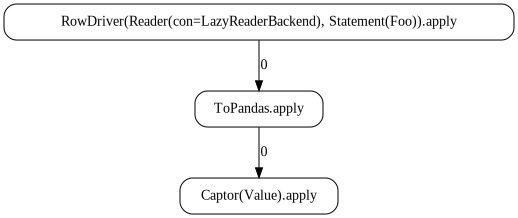

In [4]:
PROJECT.launcher(runner='graphviz').apply()

This shows our workflow consists of three tasks:
* The initial feed `Reader` task wrapping our `SOURCE` statement.
* Our actual `ToPandas` task as the only provided `PIPELINE` step.
* Finally the system-generated `Captor` task injected by the interactive launcher.

## Task Actors

[Actors](https://docs.forml.io/en/latest/workflow/actor.html) are representing the **unit of work** within the workflow - the **vertices in the task graph**.

They are interconnected using _input_ and _output_ [ports](https://docs.forml.io/en/latest/workflow/actor.html#ports).

![actor](img/actor.svg)

ForML supports a couple of different ways to [implement actors](https://docs.forml.io/en/latest/workflow/actor.html#implementation). For the sake of this tutorial we will stick just with the highlevel concept of _wrapping decorators_.

### Stateless Actor

Stateless actor represents a task whose output depends purely on its input.

Let's implement a simple stateless actor called `LowerActor` that is extracing and lower-casing a specific column from a Pandas dataframe:

In [5]:
import pandas
from forml.pipeline import wrap

@wrap.Actor.apply
def LowerActor(data: pandas.DataFrame, *, column: str) -> pandas.Series:
    # return data[column].str.lower()
    return data[column].apply(lambda v: v.lower())

This actor has a single input port (`data` parameter) and single output port (the return value). The `column` argument here is a hyperparameter.
Let's test this actor:

In [6]:
df = pandas.DataFrame({'greetings': ['Hello', 'Hola', 'Ola', 'Ciao']})

lower_actor = LowerActor(column='greetings')
lower_actor.apply(df)

0    hello
1     hola
2      ola
3     ciao
Name: greetings, dtype: object

#### Excercise: Write an actor returning a selected column as the Ascii code of its lower-cased first letter

Let's call this actor `OrdActor` and similarly to the `LowerActor` parametrize it with the target column name.

Hint: You can use the `ord()` function to turn a character to its Ascii code.

In [7]:
@wrap.Actor.apply
def OrdActor(data: pandas.DataFrame, *, column: str) -> pandas.Series:
    return data[column].apply(lambda v: ord(v[0].lower()))

To test this actor:

In [8]:
ord_actor = OrdActor(column='greetings')
ord_actor.apply(df)

0    104
1    104
2    111
3     99
Name: greetings, dtype: int64

### Stateful Actor

Stateful actors are more complex - their output is based on not just the input but also their **inner state** which it acquires during a separate phase called the _train mode_. For the normal mode we then use the term _apply mode_.

Let's implement an actor called `CenterActor` that's returning a selected column with _mean_ value removed:

In [9]:
import typing

@wrap.Actor.train  # starting with the actor train mode
def CenterActor(
    state: typing.Optional[float],  # previous state
    data: pandas.DataFrame,         # input data points
    labels: pandas.Series,          # target labels
    *,
    column: str                     # hyperparameter
) -> float:                         # new state
    return data[column].mean()


@CenterActor.apply  # finishing the CenterActor apply mode
def CenterActor(
    state: float, data: pandas.DataFrame, *, column: str
) -> pandas.DataFrame:
    return data[column] - state

The implementation has two steps:

1. In the _train mode_ the actor has three input ports the **previous state**,  the **source data** and the **target labels**. It has a single output producing a new state acquired during this training.
2. In the _apply mode_ the actor gets the recently trained **state** and the input **data** to have the mean removed.

Let's now test this actor:

In [10]:
df = pandas.DataFrame({'rating': [0.3, 0.1, 0.7, 0.6, 0.4]})

center_actor = CenterActor(column='rating')
center_actor.train(df, None)  # train mode
center_actor.apply(df)        # apply mode

0   -0.12
1   -0.32
2    0.28
3    0.18
4   -0.02
Name: rating, dtype: float64

## Operators

[Operators](https://docs.forml.io/en/latest/workflow/operator.html) are the high-level workflow entities. While actors implement the tasks, operators deal with their wiring - the actual **topology** of the task graph.

Let's create a traditional _mapper_ operator using our previously implemented actor `OrdActor`. There is a number of different ways to implement ForML operators, for simplicity we are again going to use available [wrapping decorators](https://docs.forml.io/en/latest/_auto/forml.pipeline.wrap.html):

In [11]:
Ord = wrap.Operator.mapper(OrdActor)

We can now build a true workflow using this operator as our `PIPELINE`:

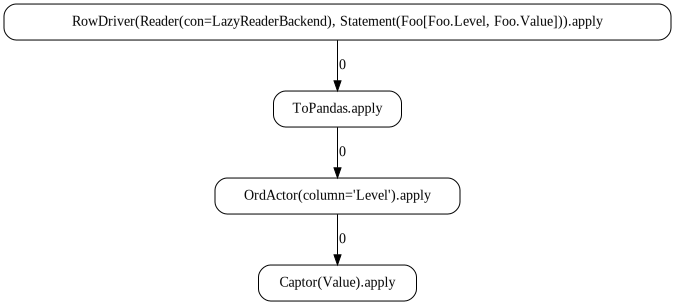

In [12]:
FEATURES = Foo.select(Foo.Level, Foo.Value)
SOURCE = (
    project.Source.query(FEATURES, labels=Foo.Label)
    >> payload.ToPandas()
)
PIPELINE = Ord(column="Level")
SOURCE.bind(PIPELINE).launcher(runner="graphviz").apply()

The `OrdActor` is now part of the processing flow.

### Excercise: Use decorators to implement a mapper for scaling values of a selected column to [0-1]

In [13]:
@wrap.Actor.train
def MinMax(
    state: typing.Optional[tuple[float, float]],
    data: pandas.DataFrame,
    labels: pandas.Series,
    *,
    column: str
) -> tuple[float, float]:  # the state is a tuple of min and max - min
    min_ = data[column].min()
    return min_, data[column].max() - min_


@wrap.Operator.mapper  # this will turn it into Operator
@MinMax.apply
def MinMax(
    state: tuple[float, float], data: pandas.DataFrame, *, column: str
) -> pandas.DataFrame:
    data[column] = (data[column] - state[0]) / state[1]
    return data

Let's confirm this can be composed as a `PIPELINE` component:

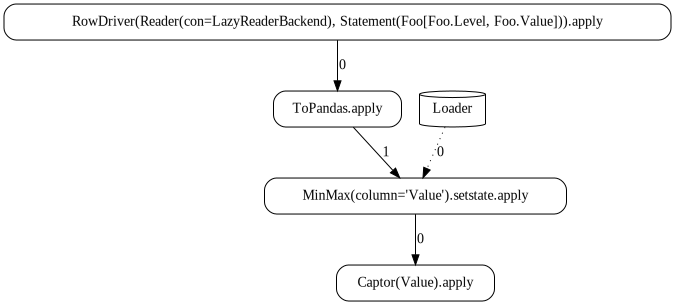

In [14]:
PIPELINE = MinMax(column='Value')

SOURCE.bind(PIPELINE).launcher(runner='graphviz').apply()

Note the extra `Loader` task providing the _state_ for the `MinMax` actor in the apply mode.

### Train-Apply Workflow Duality

Each operator carries definition of its task graph composition for both the _train_ vs _apply_ modes.

For example the `Mapper` operator plugs into the flow channels (trunk) as follows:
![Mapper](img/mapper.svg)

Sofar we've only been launching the workflow in the _apply mode_. Let's see how much different task graph is produced for the same workflow when in _train mode_.

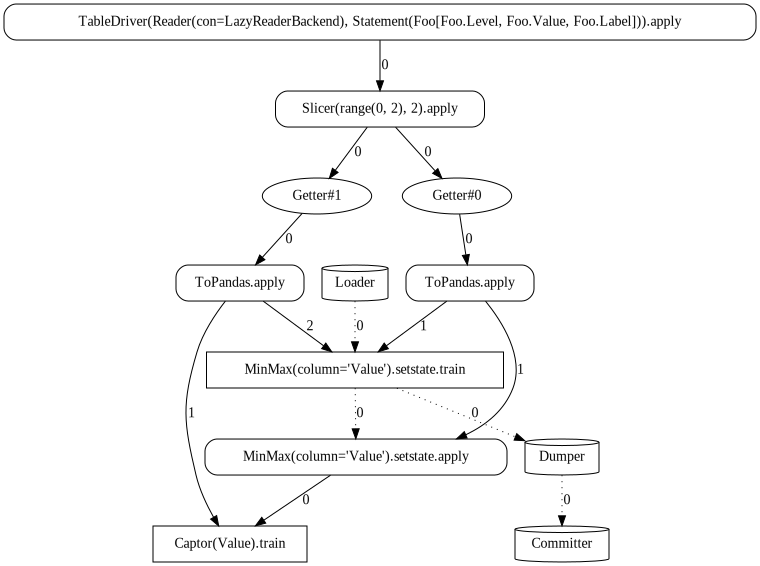

In [15]:
SOURCE.bind(PIPELINE).launcher(runner='graphviz').train()

Using the _Dask_ runner, we can use the same _launcher_ to execute the _train mode_ workflow immediately followed by the _apply mode_ to see the `MinMax` actor doing the job (`Value` is scaled between `0` and `1`):

In [16]:
launcher = SOURCE.bind(PIPELINE).launcher(runner='dask')
launcher.train()
launcher.apply()

INFO: 2023-05-28 08:13:26,744: lazy: Loading Foo
INFO: 2023-05-28 08:13:28,799: lazy: Loading Foo


,Level,Value
0,Alpha,0.218391
1,Tango,1.000000
2,Zulu,0.574713
3,Uniform,0.712644
4,Xray,0.873563
5,Victor,0.620690
6,Echo,0.057471
7,Whiskey,0.816092
8,November,0.977011
9,Yankee,0.701149


### Library Operators

Operators are often well suited for reusability. Collections of useful operators can be maintained in form of interal or [public libraries](https://docs.forml.io/en/latest/pipeline.html).
Let's employ the upstream `payload.MapReduce` operator with our `OrdActor` and `CenterActor` actors implemented previously:

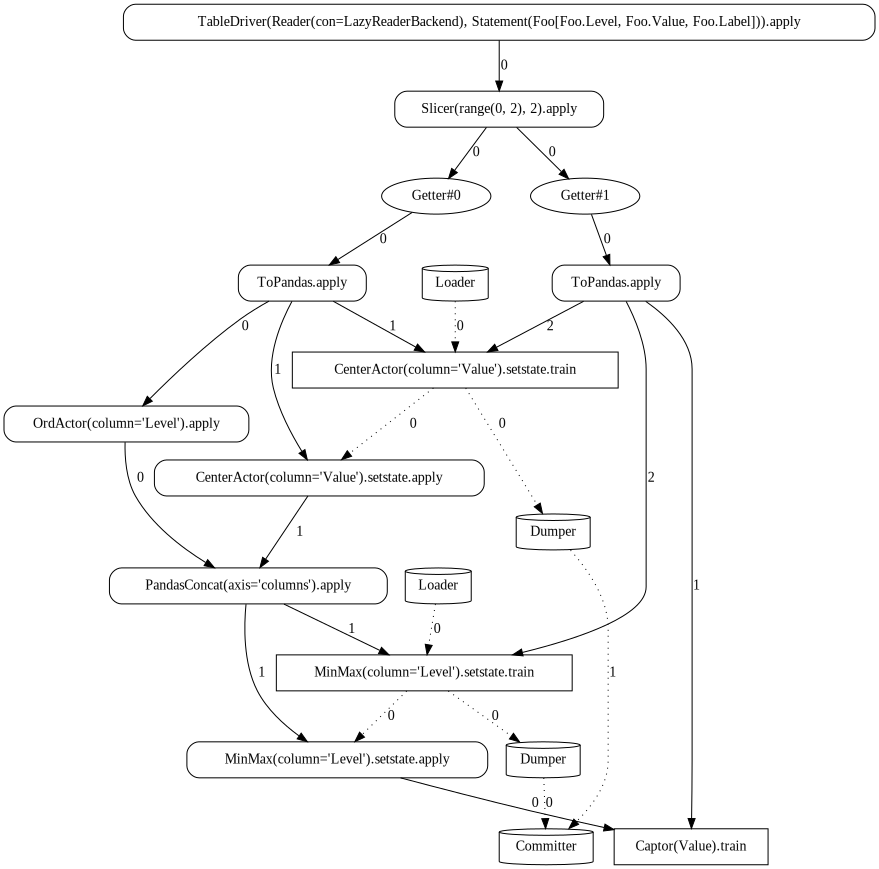

In [17]:
PIPELINE = payload.MapReduce(
    OrdActor.builder(column="Level"), CenterActor.builder(column="Value")
) >> MinMax(column="Level")

SOURCE.bind(PIPELINE).launcher(runner="graphviz").train()

We can again switch to the _Dask_ runner to execute the pipeline (in both modes) to see the processing result (this time the `MinMax` scaler is applied to the `Level` column tranformed using the `OrdActor` in parallel to the `CenterActor` removing mean from the `Value` column):

In [18]:
launcher = SOURCE.bind(PIPELINE).launcher(runner='dask')
launcher.train()
launcher.apply()

,Level,Value
0,0.00,-0.3205
1,0.76,0.3595
2,1.00,-0.0105
3,0.80,0.1095
4,0.92,0.2495
5,0.84,0.0295
6,0.16,-0.4605
7,0.88,0.1995
8,0.52,0.3395
9,0.96,0.0995


### Implementing Custom Operator

Let's implement a custom `Balancer` operator inserting a 2x2 actor into the _train_ and _apply_ paths.

![Balancer](img/balancer.svg)

* The actor steps into the _label_ and _train_ channels using its 2 input and 2 output ports
* The _apply_ channel is unaffected (balancing is only relevant to the _train mode_)

Before we focus on the operator itself, we start with a (stateless) _oversampling actor_ simply based on the [Imbalanced-learn](https://imbalanced-learn.org/stable/) library:

In [19]:
from imblearn import over_sampling

@wrap.Actor.apply
def OverSampler(
    features: pandas.DataFrame,
    labels: pandas.Series,
    *,
    random_state: typing.Optional[int] = None
):
    """Stateless actor with two input and two output ports for
    oversampling the features/labels of the minor class.
    """
    return over_sampling.RandomOverSampler(
        random_state=random_state
    ).fit_resample(features, labels)

Quick test to see imbalanced input is transformed to balanced output:

In [20]:
OverSampler(random_state=42).apply([[1], [0], [1]], [1, 0, 1])

([[1], [0], [1], [0]], [1, 0, 1, 0])

Raw operator inherits the `flow.Operator` and implements the `compose` method:

In [21]:
from forml import flow

class Balancer(flow.Operator):
    """Balancer operator inserting the provided sampler into
    the ``train`` & ``label`` paths.
    """

    def __init__(
        self,
        sampler: flow.Builder = OverSampler.builder(random_state=42),
    ):
        self._sampler = sampler

    def compose(self, scope: flow.Composable) -> flow.Trunk:
        left = scope.expand()
        sampler = flow.Worker(self._sampler, 2, 2)  # 2x2 node
        sampler[0].subscribe(left.train.publisher)  # train -> in0
        new_features = flow.Future()
        new_features[0].subscribe(sampler[0])       # out0 -> newtrain
        sampler[1].subscribe(left.label.publisher)  # label -> in1
        new_labels = flow.Future()
        new_labels[0].subscribe(sampler[1])         # out1 -> newlabel
        return left.use(
            train=left.train.extend(tail=new_features),
            label=left.label.extend(tail=new_labels),
        )

Visualizing a pipeline with this `Balancer` operator produces:

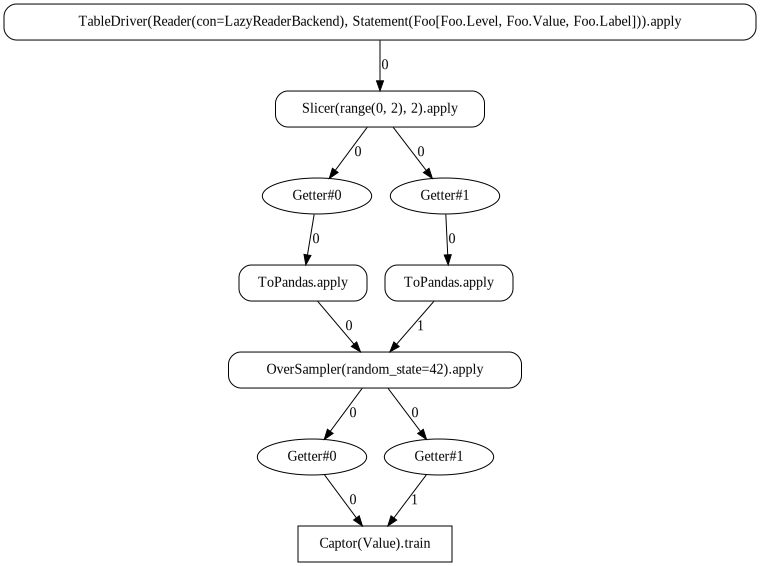

In [22]:
PIPELINE = Balancer()
SOURCE.bind(PIPELINE).launcher(runner='graphviz').train()

Quick test to see the number of labels when engaging our `Balancer` confirms they are now balanced:

In [23]:
SOURCE.bind(PIPELINE).launcher.train().labels.value_counts()

Label
1    14
0    14
Name: count, dtype: int64

### Operator Unit Testing

ForML provides elegant operator [unit testing facility](https://docs.forml.io/en/latest/testing.html):

In [24]:
from forml import testing

class TestBalancer(testing.operator(Balancer)):

    default_oversample = (
        testing.Case()
        .train([[1], [1], [0]], [1, 1, 0])                   # input
        .returns([[1], [1], [0], [0]], labels=[1, 1, 0, 0])  # assert
    )

Tests are normally launched from CLI so the following wouldn't be needed:

In [25]:
import unittest
suite = unittest.TestSuite()
suite.addTest(TestBalancer('test_default_oversample'))
unittest.TextTestRunner().run(suite)

.
----------------------------------------------------------------------
Ran 1 test in 1.910s

OK


<unittest.runner.TextTestResult run=1 errors=0 failures=0>

### Auto-wrapping 3rd-party Components

To simplify integration of existing 3rd party algorithms (i.e. transformers/estimators), ForML allows to transparently [turn them into operators](https://docs.forml.io/en/latest/workflow/operator.html#auto-wrapped-operators) right upon importing:

In [26]:
with wrap.importer():
    from sklearn.linear_model import LogisticRegression

isinstance(LogisticRegression(), flow.Operator)

True

## Pipeline

Let's now put all this together and compose a full pipeline with the different transforming operators defined previously and the final classifier:

In [27]:
PIPELINE = (
    Balancer()
    >> payload.MapReduce(
        OrdActor.builder(column="Level"),
        CenterActor.builder(column="Value"),
    )
    >> MinMax(column="Level")
    >> LogisticRegression(random_state=42)
)

### Excercise: Compare the final train/apply task graphs

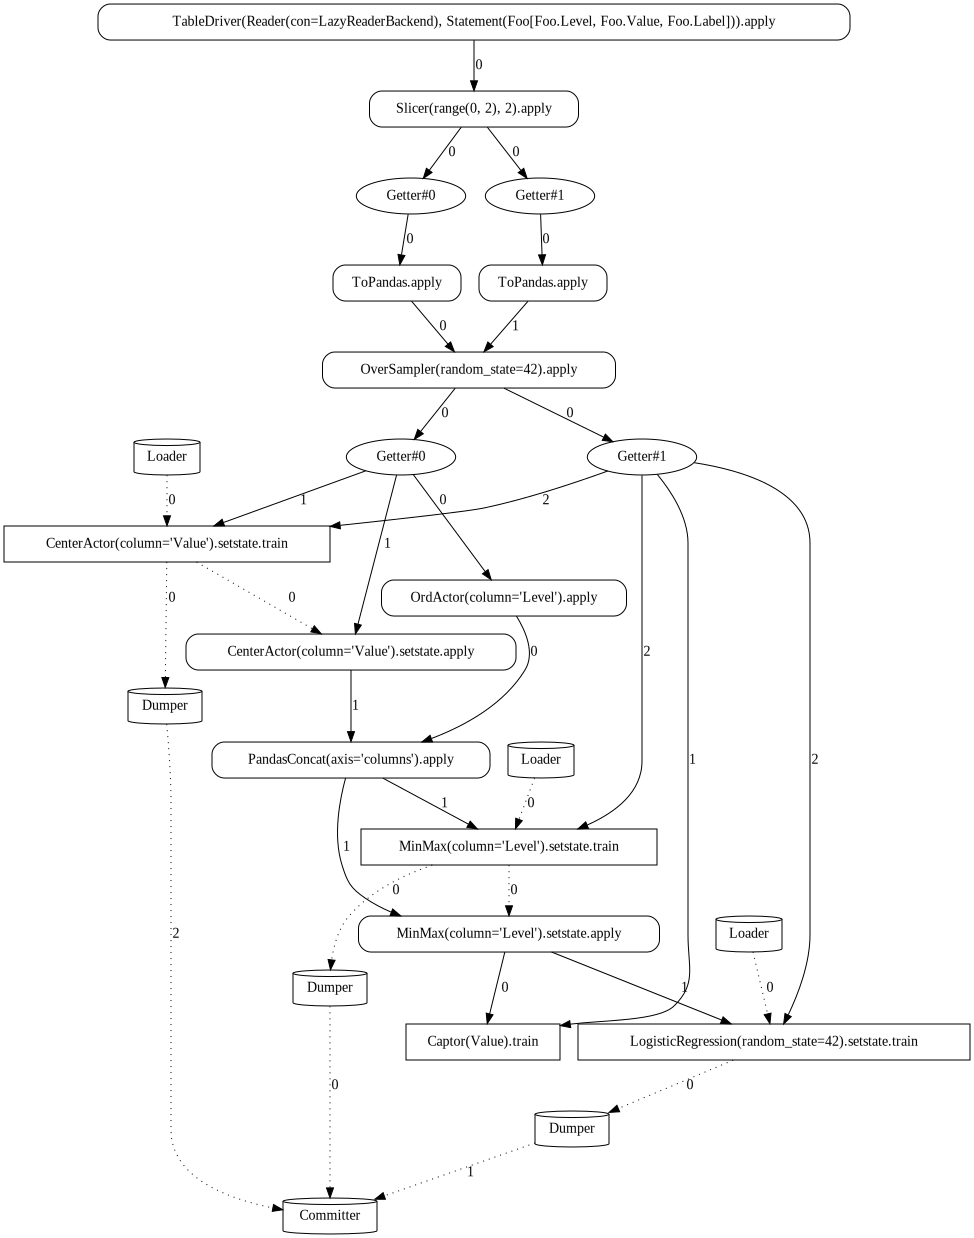

In [28]:
SOURCE.bind(PIPELINE).launcher(runner="graphviz").train()

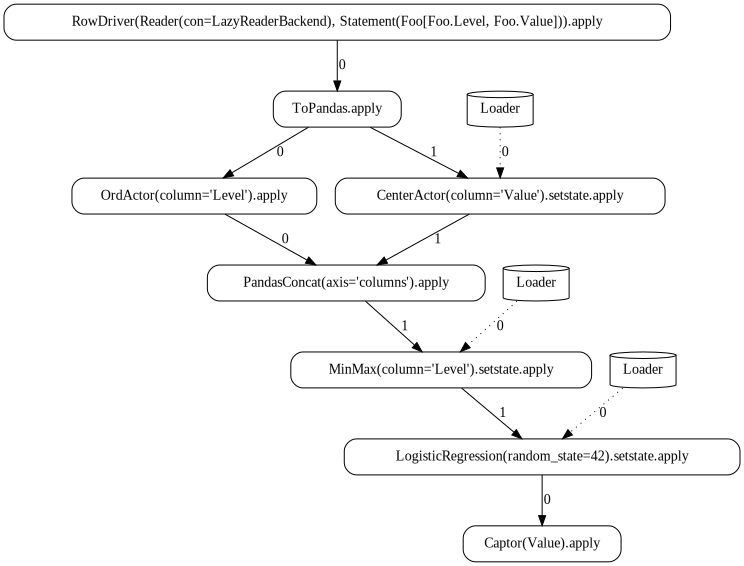

In [29]:
SOURCE.bind(PIPELINE).launcher(runner="graphviz").apply()